In [3]:
# Imports
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets

import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.models as models

import os
import time
import sys
import torch.quantization
import matplotlib.pyplot as plt

In [2]:
# VGG architecture with custom classifier layers and added Quant Layers
class VGG(torch.nn.Module):
    def __init__(self, vgg='vgg16', data_set='CIFAR10', pretrained=False):
        super(VGG, self).__init__()
        self.features = models.__dict__[vgg](pretrained=pretrained).features
        
        classifier = []
        if 'CIFAR' in data_set:
            num_class = int(data_set.split("CIFAR")[1])
            
            classifier.append(nn.Linear(512, 512))
            # classifier.append(nn.ReLU())
            classifier.append(nn.Dropout(p=0.2))
            # classifier.append(nn.Linear(512, 256))
            # classifier.append(nn.ReLU())
            # classifier.append(nn.Dropout(p=0.2))
            classifier.append(nn.Linear(512, num_class))
            
            self.quant = torch.quantization.QuantStub()
            self.dequant = torch.quantization.DeQuantStub()
        else:
            raise RuntimeError("Not expected data flag !!!")

        self.classifier = torch.nn.Sequential(*classifier)
        
    def forward(self, x):
        x = self.quant(x)
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        x = self.dequant(x)
        return x

In [3]:
# class VGG(nn.Module):
#     def __init__(self, features, num_classes=10,init_weights=False):
#         super(VGG, self).__init__()
#         self.features = features
#         self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
#         self.classifier = nn.Sequential(
#             nn.Linear(512*7*7, 512),
#             nn.ReLU(),
#             nn.Dropout(p=0.5),
#             nn.Linear(512, 512),
#             nn.ReLU(),
#             nn.Dropout(p=0.5),
#             nn.Linear(512, num_classes)
#         )
#         # add the quantize part
# #         self.quant = torch.quantization.QuantStub()
# #         self.dequant = torch.quantization.DeQuantStub()

#         if init_weights:
#             self._initialize_weights()

#     def forward(self,x):
# #         x = self.quant(x)
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x,start_dim=1)
#         # x = x.mean([2, 3])
#         x = self.classifier(x)
# #         x = self.dequant(x)
#         return x

#     def _initialize_weights(self):
#         for module in self.modules():
#             if isinstance(module, nn.Conv2d):
#                 # nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#                 nn.init.xavier_uniform_(module.weight)
#                 if module.bias is not None:
#                     nn.init.constant_(module.bias,0)
#             elif isinstance(module,nn.Linear):
#                 nn.init.xavier_uniform_(module.weight)
#                 # nn.init.normal_(m.weight, 0, 0.01)
#                 nn.init.constant_(module.bias,0)

In [4]:
# cfgs = {
#     'vgg11':[64,'M',128,'M',256,256,'M',512,512,'M',512,512,'M'],
#     'vgg13':[64,64,'M',128,128,'M',256,256,'M',512,512,'M',512,512,'M'],
#     'vgg16':[64,64,'M',128,128,'M',256,256,256,'M',512,512,512,'M',512,512,512,'M'],
#     'vgg19':[64,64,'M',128,128,'M',256,256,256,256,'M',512,512,512,512,'M',512,512,512,512,'M'],
# }

In [5]:
# def make_features(cfg:list):
#     layers = []
#     in_channels = 3
#     for v in cfg:
#         if v == 'M':
#             layers += [nn.MaxPool2d(kernel_size=2,stride=2)]
#         else:
#             conv2d = nn.Conv2d(in_channels,v,kernel_size=3,padding=1)
#             layers += [conv2d,nn.ReLU(True)]
#             in_channels = v
#     return nn.Sequential(*layers)

In [6]:
# def vgg(model_name='vgg16',**kwargs):
#     try:
#         cfg = cfgs[model_name]
#     except:
#         print("Warning: model number {} not in cfgs dict!".format(model_name))
#         exit(-1)
#     model = VGG(make_features(cfg),**kwargs)
#     return model

In [69]:
# Class to track average and current values of metrics
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

# To compute top-k accuracy
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


# To evaluate model performance 
def evaluate(model, criterion, data_loader, neval_batches):
    model.eval()
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    cnt = 0
    with torch.no_grad():
        for image, target in data_loader:
            output = model(image)
            loss = criterion(output, target)
            cnt += 1
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            print('.', end = '')
            top1.update(acc1[0], image.size(0))
            top5.update(acc5[0], image.size(0))
            if cnt >= neval_batches:
                 return top1, top5

    return top1, top5


# Compute inference time on batch of images
def run_benchmark(model_file, img_loader):
    elapsed = 0
    model = torch.jit.load(model_file)
    model.eval()
    num_batches = 5
    # Run the scripted model on a few batches of images
    for i, (images, target) in enumerate(img_loader):
        if i < num_batches:
            start = time.time()
            output = model(images)
            end = time.time()
            elapsed = elapsed + (end-start)
        else:
            break
    num_images = images.size()[0] * num_batches
    
    print('Elapsed time: %3.2f ms' % (elapsed/num_images*1000))
    return elapsed/num_images*1000

# Compute model size
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    size = os.path.getsize("temp.p")/1e6
    os.remove('temp.p')
    return size

In [8]:
# def load_model(model_file=None):
#     model_name = "vgg16"
#     model = vgg(model_name=model_name, num_classes=10, init_weights=False)
#     if model_file is not None:
#         state_dict = torch.load(model_file)
#         model.load_state_dict(state_dict)
# #     model.to('cpu')
#     return model

In [9]:
# Download and transform data to get data loaders 
def prepare_data_loaders(batch_size=128, data_root='./data', train=True, val=True):    
    dataset = datasets.CIFAR10(
                root=data_root, train=True, download=True,
                transform=transforms.Compose([
                    transforms.RandomCrop(32, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor()
                ])
            )
    train_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size)
    
    dataset_test = datasets.CIFAR10(
                    root=data_root, train=False, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor()
                    ])
                )
    test_loader = torch.utils.data.DataLoader(
        dataset=dataset_test,
        batch_size=batch_size)

    return train_loader, test_loader

In [10]:
# def prepare_data_loaders_old(data_path):
#     traindir = os.path.join(data_path, 'train')
#     valdir = os.path.join(data_path, 'val')
#     normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225])

#     dataset = torchvision.datasets.ImageFolder(
#         traindir,
#         transforms.Compose([
#             transforms.RandomResizedCrop(224),
#             transforms.RandomHorizontalFlip(),
#             transforms.ToTensor(),
#             normalize,
#         ]))
#     print("dataset_train : %d" % (len(dataset)))

#     dataset_test = torchvision.datasets.ImageFolder(
#         valdir,
#         transforms.Compose([
#             transforms.Resize(256),
#             transforms.CenterCrop(224),
#             transforms.ToTensor(),
#             normalize,
#         ]))
#     print("dataset_test : %d" % (len(dataset_test)))

#     train_sampler = torch.utils.data.RandomSampler(dataset)
#     test_sampler = torch.utils.data.SequentialSampler(dataset_test)

#     data_loader = torch.utils.data.DataLoader(
#         dataset, batch_size=train_batch_size,
#         sampler=train_sampler)

#     data_loader_test = torch.utils.data.DataLoader(
#         dataset_test, batch_size=eval_batch_size,
#         sampler=test_sampler)

#     return data_loader, data_loader_test

In [11]:
# Compute top-1 accuracy
def evaluate2(model, test_loader):
    correct = 0
    total = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    with torch.no_grad():
        for i, (img, target) in enumerate(test_loader):
            img = img.to(device)
            out = model(img)
            pred = out.max(1)[1].detach().cpu().numpy()
            target = target.cpu().numpy()
            correct += (pred==target).sum()
            total += len(target)
    return correct / total

In [12]:
# Train model iteratively and evaluate on test data
def train_model(model, epochs, train_loader, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 70, 0.1)
    model.to(device)

    best_acc = -1
    for epoch in range(epochs):
        model.train()
        for i, (img, target) in enumerate(train_loader):
            img, target = img.to(device), target.to(device)
            optimizer.zero_grad()
            out = model(img)
            loss = F.cross_entropy(out, target)
            loss.backward()
            optimizer.step()
            
            if i%100==0:
                print("Epoch %d/%d, iter %d/%d, loss=%.4f"%(epoch, epochs, i, len(train_loader), loss.item()))
        
        model.eval()
        acc = evaluate2(model, test_loader)
        print("Epoch %d/%d, Acc = %.4f"%(epoch, epochs, acc))
        
        if best_acc < acc:
#             torch.save( model, saved_model_dir + float_model_file )
            torch.save( model, saved_model_dir + quantized_base_model_file )
            best_acc = acc
        
        scheduler.step()
    print("Best Acc = %.4f"%(best_acc))

In [13]:
torch.manual_seed(191009)

In [14]:
saved_model_dir = 'model/'
quantized_base_model_file = 'vgg16_quantized_base.pth'
scripted_float_model_file = 'vgg16_quantization_scripted.pth'
scripted_default_quantized_model_file = 'vgg16_quantization_scripted_default_quantized.pth'
scripted_optimal_quantized_model_file = 'vgg16_quantization_scripted_optimal_quantized.pth'

In [15]:
# train_batch_size = 30
# eval_batch_size = 30

In [16]:
# Download and prepare dataset
data_loader, data_loader_test = prepare_data_loaders()
criterion = nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified


In [17]:
# Create baseline VGG model and load on to GPU
model = VGG()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [19]:
# Train baseline model for 20 epochs
train_model(model, 20, data_loader, data_loader_test)

Epoch 0/20, iter 0/391, loss=2.2997
Epoch 0/20, iter 100/391, loss=2.3014
Epoch 0/20, iter 200/391, loss=2.3049
Epoch 0/20, iter 300/391, loss=2.2416
Epoch 0/20, Acc = 0.1735
Epoch 1/20, iter 0/391, loss=2.1124
Epoch 1/20, iter 100/391, loss=1.8449
Epoch 1/20, iter 200/391, loss=2.0281
Epoch 1/20, iter 300/391, loss=1.8623
Epoch 1/20, Acc = 0.2992
Epoch 2/20, iter 0/391, loss=1.7094
Epoch 2/20, iter 100/391, loss=1.7246
Epoch 2/20, iter 200/391, loss=1.6914
Epoch 2/20, iter 300/391, loss=1.5469
Epoch 2/20, Acc = 0.4145
Epoch 3/20, iter 0/391, loss=1.5210
Epoch 3/20, iter 100/391, loss=1.4635
Epoch 3/20, iter 200/391, loss=1.4404
Epoch 3/20, iter 300/391, loss=1.2986
Epoch 3/20, Acc = 0.5246
Epoch 4/20, iter 0/391, loss=1.2559
Epoch 4/20, iter 100/391, loss=1.2189
Epoch 4/20, iter 200/391, loss=1.2113
Epoch 4/20, iter 300/391, loss=1.1249
Epoch 4/20, Acc = 0.5980
Epoch 5/20, iter 0/391, loss=1.1163
Epoch 5/20, iter 100/391, loss=0.9269
Epoch 5/20, iter 200/391, loss=1.1807
Epoch 5/20, i

In [21]:
def load_model(path):
    return torch.load(path)

In [22]:
# Evaluate baseline model
float_model = load_model(saved_model_dir + quantized_base_model_file).to('cpu')

print('\n Before quantization: \n', float_model)
float_model.eval()


 Before quantization: 
 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [51]:
sizes = []
infs = []
top1_accs = []
top5_accs = []

In [ ]:
# Evaluate metrics of baseline model

In [52]:
num_eval_batches = 10
batch_size = 128

print(f"Size of baseline model = {print_size_of_model(float_model) :.2f} MB")
sizes.append(print_size_of_model(float_model))

Size of baseline model = 59.94 MB


In [53]:
top1, top5 = evaluate(float_model, criterion, data_loader_test, neval_batches=num_eval_batches)
print()
print('Top-1 Evaluation accuracy on %d images, %2.2f%%'%(num_eval_batches * batch_size, top1.avg))
print('Top-5 Evaluation accuracy on %d images, %2.2f%%'%(num_eval_batches * batch_size, top5.avg))
top1_accs.append(top1.avg)
top5_accs.append(top5.avg)

..........
Top-1 Evaluation accuracy on 1280 images, 84.38%
Top-5 Evaluation accuracy on 1280 images, 99.14%


In [54]:
torch.jit.save(torch.jit.script(float_model), saved_model_dir + scripted_float_model_file) # save un_quantized model

In [55]:
# Prepare model to quantize 

num_calibration_batches = 10
myModel = load_model(saved_model_dir + quantized_base_model_file).to('cpu')
myModel.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [56]:
# Specify quantization configuration
# Start with simple min/max range estimation and per-tensor quantization of weights
myModel.qconfig = torch.quantization.default_qconfig
print(myModel.qconfig)
torch.quantization.prepare(myModel, inplace=True)

QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric){})


VGG(
  (features): Sequential(
    (0): Conv2d(
      3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
    )
    (1): ReLU(inplace=True)
    (2): Conv2d(
      64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
    )
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(
      64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
    )
    (6): ReLU(inplace=True)
    (7): Conv2d(
      128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
    )
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(
      128, 256, kerne

In [57]:
# Calibrate with the training set
print('\nPost Training Quantization Prepare: Inserting Observers by Calibrate')
evaluate(myModel, criterion, data_loader, neval_batches=num_calibration_batches)
print("Calibrate done")


Post Training Quantization Prepare: Inserting Observers by Calibrate
..........Calibrate done


In [58]:
# Convert to quantized model
torch.quantization.convert(myModel, inplace=True)
print('Post Training Quantization: Convert done')

Post Training Quantization: Convert done


In [ ]:
# Evaluate metrics of default quantized model

In [59]:
print('\n After quantization: \n',myModel)

print(f"Size of model after quantization = {print_size_of_model(myModel) :.2f} MB")
sizes.append(print_size_of_model(myModel))


 After quantization: 
 VGG(
  (features): Sequential(
    (0): QuantizedConv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.09904821217060089, zero_point=49, padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.4555126428604126, zero_point=85, padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): QuantizedConv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.6358559131622314, zero_point=82, padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): QuantizedConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.7569528222084045, zero_point=71, padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): QuantizedConv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), scale=1.3964283466339111, zero_point=62, padding=(1, 1))
    (11): ReLU(inplace=True)
    (

In [60]:
top1, top5 = evaluate(myModel, criterion, data_loader_test, neval_batches=num_eval_batches)

print()
print('Top-1 Evaluation accuracy on %d images, %2.2f%%'%(num_eval_batches * batch_size, top1.avg))
print('Top-5 Evaluation accuracy on %d images, %2.2f%%'%(num_eval_batches * batch_size, top5.avg))
top1_accs.append(top1.avg)
top5_accs.append(top5.avg)

..........
Top-1 Evaluation accuracy on 1280 images, 83.44%
Top-5 Evaluation accuracy on 1280 images, 99.14%


In [61]:
torch.jit.save(torch.jit.script(myModel), saved_model_dir + scripted_default_quantized_model_file) # save default_quantized model

In [62]:
# Create optimally quantized model
per_channel_quantized_model = load_model(saved_model_dir + quantized_base_model_file).to('cpu')

# Specify quantization configuration
per_channel_quantized_model.eval()
per_channel_quantized_model.qconfig = torch.quantization.get_default_qconfig('fbgemm') # set the quantize config

In [63]:
print('\n optimal quantize config: ')
print(per_channel_quantized_model.qconfig)


 optimal quantize config: 
QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})


In [64]:
# Calibrate with the training set
torch.quantization.prepare(per_channel_quantized_model, inplace=True) # execute the quantize config
evaluate(per_channel_quantized_model, criterion, data_loader, num_calibration_batches) # calibrate
print("Calibrate done")

..........Calibrate done


In [65]:
# Convert to optimally quantized model
torch.quantization.convert(per_channel_quantized_model, inplace=True) # convert to quantize model
print('Post Training Optimal Quantization: Convert done')

Post Training Optimal Quantization: Convert done


In [ ]:
# Evaluate metrics of optimally quantized model

In [66]:
print(f"Size of model after optimal quantization = {print_size_of_model(per_channel_quantized_model) :.2f} MB")
sizes.append(print_size_of_model(per_channel_quantized_model))

Size of model after optimal quantization = 15.10 MB


In [67]:
top1, top5 = evaluate(per_channel_quantized_model, criterion, data_loader_test, neval_batches=num_eval_batches) # test acc

print()
print('Top-1 Evaluation accuracy on %d images, %2.2f%%'%(num_eval_batches * batch_size, top1.avg))
print('Top-5 Evaluation accuracy on %d images, %2.2f%%'%(num_eval_batches * batch_size, top5.avg))
top1_accs.append(top1.avg)
top5_accs.append(top5.avg)

..........
Top-1 Evaluation accuracy on 1280 images, 84.45%
Top-5 Evaluation accuracy on 1280 images, 99.14%


In [68]:
torch.jit.save(torch.jit.script(per_channel_quantized_model), saved_model_dir + scripted_optimal_quantized_model_file) # save quantized model

In [ ]:
# Evaluate inference time metric

In [70]:
print("\nInference time compare: ")
infs.append(run_benchmark(saved_model_dir + scripted_float_model_file, data_loader_test))
infs.append(run_benchmark(saved_model_dir + scripted_default_quantized_model_file, data_loader_test))
infs.append(run_benchmark(saved_model_dir + scripted_optimal_quantized_model_file, data_loader_test))


Inference time compare: 
Elapsed time: 1.79 ms
Elapsed time: 3.29 ms
Elapsed time: 3.26 ms


   | Parameters | Original Model | Default Quantized Model | Optimal Quantized Model |
   |:-:|:-:|:-:|:-:|
   | Model Size           |    59.94 MB      |         15.02 MB          |        15.10 MB    |     
   | Top-1 Test Accuracy  |    84.37 %       |         83.43 %           |        84.45 %     |    
   | Top-5 Test Accuracy  |    99.14 %       |         99.14 %           |        99.14 %     |    
   | Inference Time       |    1.79 ms       |         3.29 ms           |        3.26 ms     |


    -----------------------------------------------------------------------------------------------
                          | Original Model   | Default Quantized Model   | Optimal Quantized Model 
    Model Size:           |    59.94 MB      |         15.02 MB          |        15.10 MB          
    Top-1 Test Accuracy:  |    84.37 %       |         83.43 %           |        84.45 %         
    Top-5 Test Accuracy:  |    99.14 %       |         99.14 %           |        99.14 %          
    Inference Time:       |    1.79 ms       |         3.29 ms           |        3.26 ms           
    ----------------------------------------------------------------------------------------------

In [ ]:
# Prepare plots of metrics of each type of quantization and compare with Baseline model

In [5]:
labels = ['Baseline Model', 'Quantized Model', 'Optimally Quantized Model']

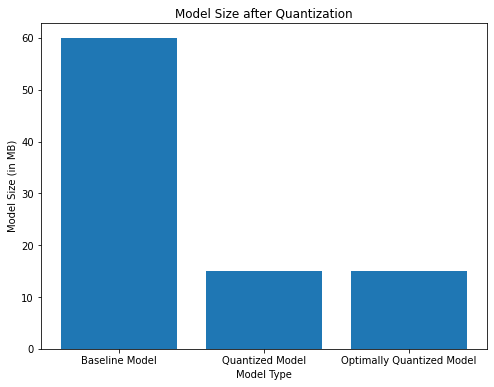

In [72]:
plt.figure(figsize=(8, 6))
plt.bar(np.arange(3), sizes)
plt.xticks(np.arange(3), labels)
plt.xlabel('Model Type')
plt.ylabel('Model Size (in MB)')
plt.title('Model Size after Quantization')
plt.show()

In [76]:
top1_accs

[tensor(84.3750), tensor(83.4375), tensor(84.4531)]

In [77]:
top5_accs

[tensor(99.1406), tensor(99.1406), tensor(99.1406)]

In [2]:
top1_accs = [84.3750, 83.4375, 84.4531]
top5_accs = [99.1406, 99.1406, 99.1406]

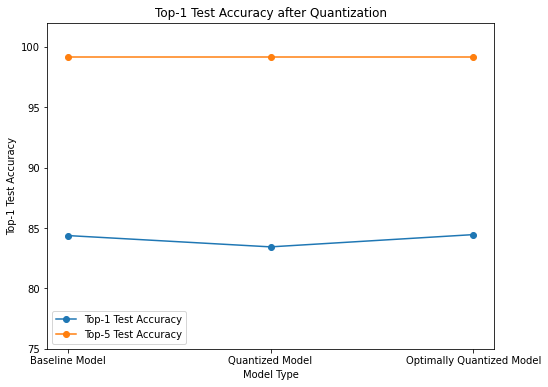

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(top1_accs, marker='o', label='Top-1 Test Accuracy')
plt.plot(top5_accs, marker='o', label='Top-5 Test Accuracy')

plt.ylim(75, 102)
plt.xticks(np.arange(3), labels)
plt.xlabel('Model Type')
plt.ylabel('Top-1 Test Accuracy')
plt.title('Top-1 Test Accuracy after Quantization')
plt.legend()
plt.show()

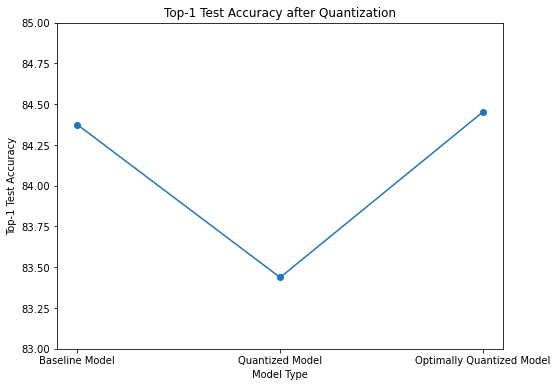

In [88]:
plt.figure(figsize=(8, 6))
# plt.bar(np.arange(3), accs)
plt.plot(top1_accs, marker='o')
plt.ylim(83, 85)
plt.xticks(np.arange(3), labels)
plt.xlabel('Model Type')
plt.ylabel('Top-1 Test Accuracy')
plt.title('Top-1 Test Accuracy after Quantization')
plt.show()

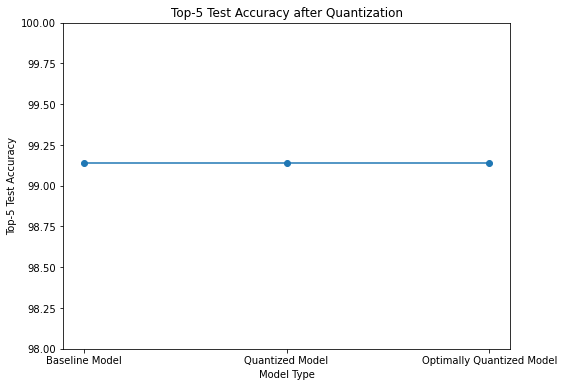

In [84]:
plt.figure(figsize=(8, 6))
# plt.bar(np.arange(3), accs)
plt.plot(top5_accs, marker='o')
plt.ylim(98, 100)
plt.xticks(np.arange(3), labels)
plt.xlabel('Model Type')
plt.ylabel('Top-5 Test Accuracy')
plt.title('Top-5 Test Accuracy after Quantization')
plt.show()

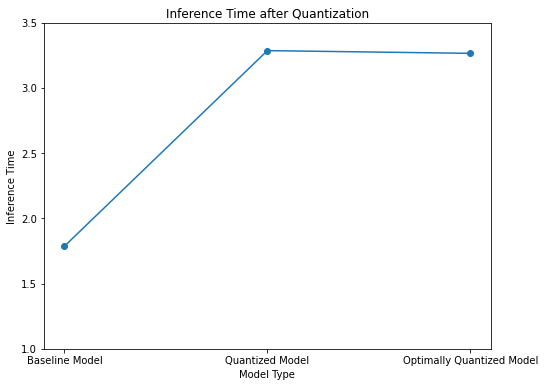

In [85]:
plt.figure(figsize=(8, 6))
# plt.bar(np.arange(3), infs)
plt.plot(infs, marker='o')
plt.ylim(1, 3.5)
plt.xticks(np.arange(3), labels)
plt.xlabel('Model Type')
plt.ylabel('Inference Time')
plt.title('Inference Time after Quantization')
plt.show()

In [ ]:
# ResNet Plots

In [103]:
sizes = [44.8, 11.305, 11.394]
accs = [0.73, 0.7288, 0.7247]
infs = [0, 1, 1]
labels = ['Baseline Model', 'Quantized Model', 'Optimally Quantized Model']

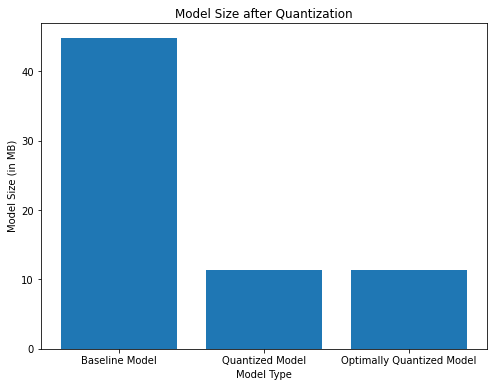

In [104]:
plt.figure(figsize=(8, 6))
plt.bar(np.arange(3), sizes)
plt.xticks(np.arange(3), labels)
plt.xlabel('Model Type')
plt.ylabel('Model Size (in MB)')
plt.title('Model Size after Quantization')
plt.show()

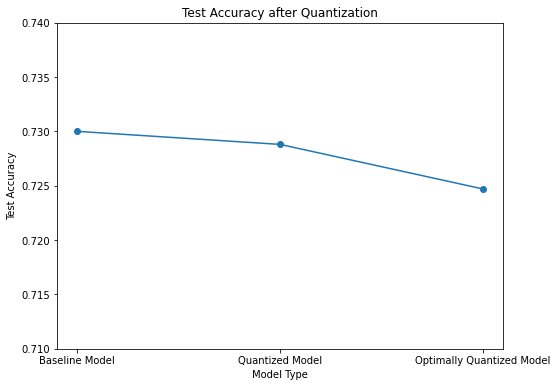

In [108]:
plt.figure(figsize=(8, 6))
# plt.bar(np.arange(3), accs)
plt.plot(accs, marker='o')
plt.ylim(0.71, 0.74)
plt.xticks(np.arange(3), labels)
plt.xlabel('Model Type')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy after Quantization')
plt.show()

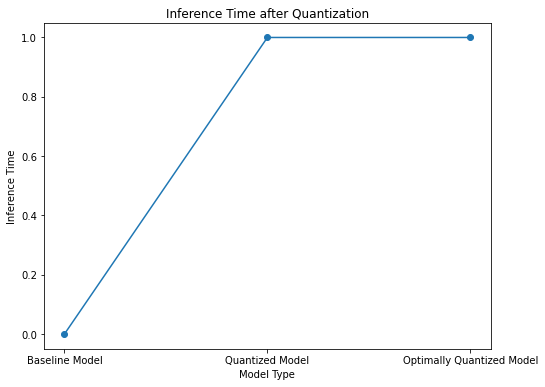

In [110]:
plt.figure(figsize=(8, 6))
# plt.bar(np.arange(3), infs)
plt.plot(infs, marker='o')
# plt.ylim(0, 3.5)
plt.xticks(np.arange(3), labels)
plt.xlabel('Model Type')
plt.ylabel('Inference Time')
plt.title('Inference Time after Quantization')
plt.show()